### IMPORTS

In [14]:
import torch
torch.manual_seed(0)
import torchvision
import numpy as np
import torchvision.models as models
import torchvision.transforms as T
from IPython.display import display
from torch import nn
import PIL
import ast
import cv2

from utils import preprocess_image

### TEST IMAGE

In [15]:
im_path = '/home/alexander/Documents/cnn_explainer/1c0cc8f0-772a-4230-8d13-a065fc355d6f-2_270.png'

my_transform = T.Compose([
        T.Resize(1200),
        T.CenterCrop(1200),
        T.ToTensor(),
        T.Normalize(
            mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

image = cv2.imread(im_path)
image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
pil_image = PIL.Image.fromarray(np.uint8(image)).convert('RGB')

tensor_image = my_transform(pil_image).unsqueeze(0).float()

### MODEL

In [18]:
model = models.resnet18()
model.fc = nn.Linear(512, 6)
checkpoint = torch.load("/home/alexander/Documents/docreader/resources/orient_class_resnet18_bigger_bs1_tmp_fixed.pth", map_location=torch.device('cpu'))
new_checkpoint = {}
for item in checkpoint :
    new_checkpoint[item[9:]] = checkpoint[item]
model.load_state_dict(new_checkpoint)

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### RAW PREDICTION

In [19]:
classes = ["1", "2", "0", "90", "180", "270"]
output = model(tensor_image)

columns_out, orientation_out = output[:, :2], output[:, 2:]

_, columns_predicted = torch.max(columns_out, 1)
_, orientation_predicted = torch.max(orientation_out, 1)

columns, orientation = int(columns_predicted[0]), int(orientation_predicted[0])
columns_predict = classes[columns]
angle_predict = classes[2 + orientation]

print("Columns: ", columns_predict)
print("Orientation: ", angle_predict)

Columns:  2
Orientation:  0


### AREA IMPORTANCE HEATMAP WITH OCCLUSSIONS

In [87]:
loss_function = torch.nn.MSELoss()

def generate_area_importance_heatmap_with_occlusions(image, annotation, block_size=60):
    image = np.array(image)
    
    height, width, channels = image.shape
    
    columns = width // block_size
    rows =  height // block_size
    
    heatmap = np.zeros((columns, rows))
    
    for row in range(rows):
        for column in range(columns):
            x = column*block_size
            y = row*block_size
            
            top = int(y)
            left = int(x)
            right = left+block_size
            bottom = top+block_size
            
            tmp_image = np.copy(image)

            noise = np.random.rand(block_size, block_size, 3)*255
            tmp_image[int(top):int(bottom), int(left):int(right)] = noise
            tmp_image = PIL.Image.fromarray(tmp_image)
            
            preprocessed_image = my_preprocessing(tmp_image)
            prediction = model(preprocessed_image).clamp(min=-1, max=1)
            loss = round(float(loss_function(prediction, annotation)), 4)
            
            heatmap[column, row] = loss
            print(row, column)

    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    heatmap = np.clip(heatmap, 0, 1)
    heatmap = heatmap * 255
    heatmap = np.uint8(heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    heatmap = cv2.resize(heatmap, (width, height), interpolation=cv2.INTER_NEAREST)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    overlayed = cv2.addWeighted(image, 1, heatmap, 0.75, 0)
    combined = np.concatenate((image, heatmap, overlayed), axis=1)
    
    return combined

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11


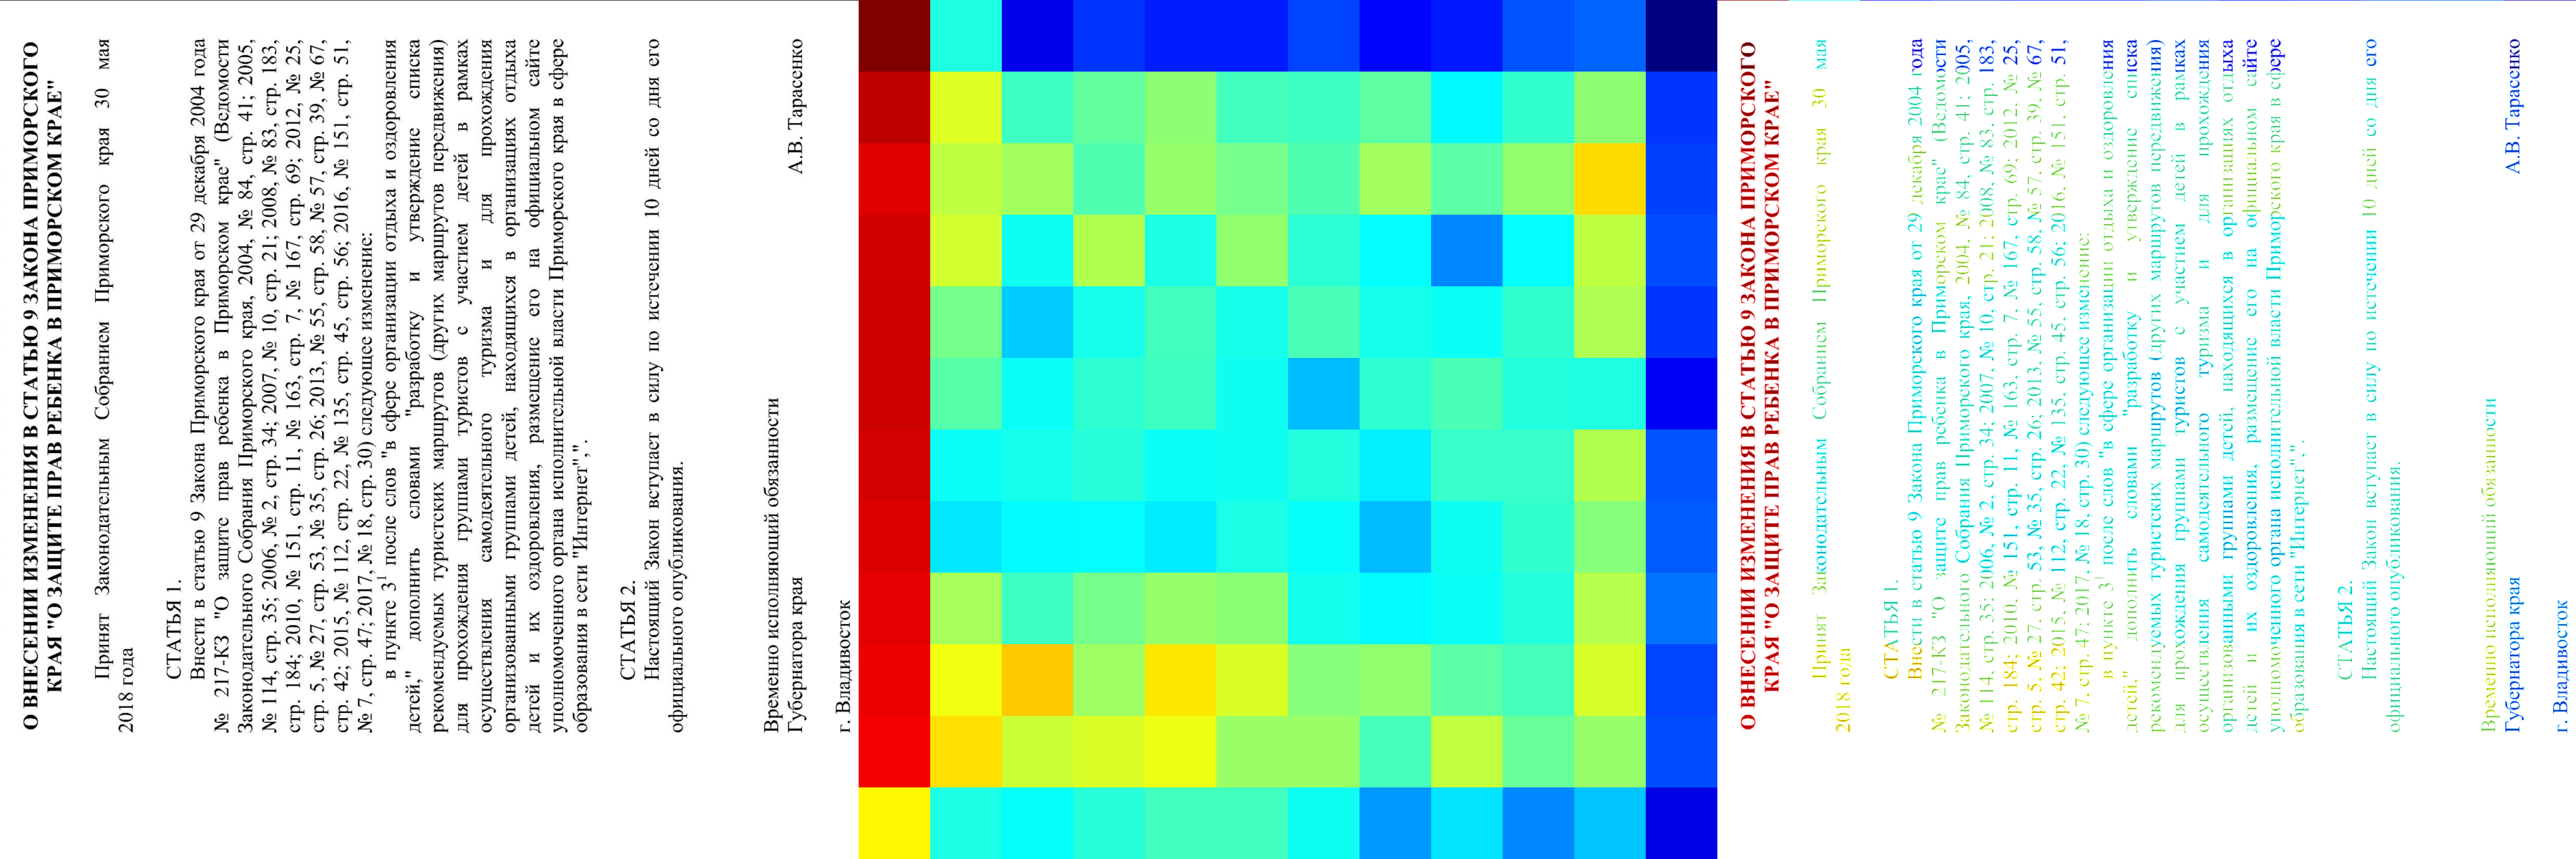

In [88]:
output = model(preprocessed_image)
occlusion_importance_heatmap = generate_area_importance_heatmap_with_occlusions(np.array(TEST_IMAGE), output)
display(PIL.Image.fromarray(occlusion_importance_heatmap))